In [10]:
import pydicom as dicom 
from skimage import io
from skimage.morphology import opening,closing,disk


dir = "HeartCT/"
img = dicom.read_file("HeartCT/1-001.dcm")

img = img.pixel_array

In [8]:
print(img.shape)
print(img.dtype)


(512, 512)
int16


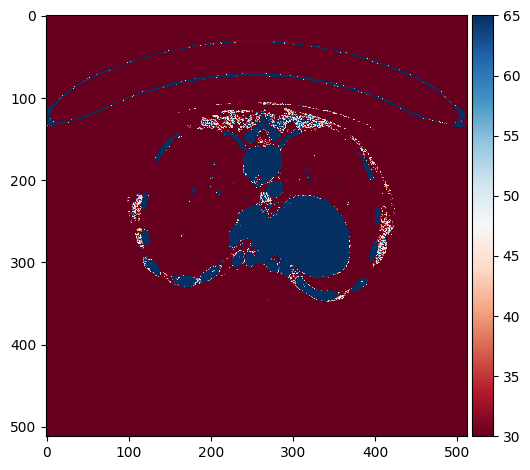

In [9]:
io.imshow(img,vmin=30,vmax=65)
io.show()

In [15]:
import numpy as np 

bloodroi = io.imread(dir + "BloodROI.png")
bloodGT = io.imread(dir + "BloodGT.png")
myocroi = io.imread(dir + "MyocardiumROI.png")


bloodroi_px = img[bloodroi>0]
myc_px = img[myocroi>0]
gt_px = img[bloodGT>0]


u_blood = np.mean(bloodroi_px)
std_blood = np.std(bloodroi_px)

u_m = np.mean(myc_px)
std_m = np.std(myc_px)


In [46]:
from skimage import measure
from skimage.color import label2rgb
from scipy.stats import norm
from scipy.spatial import distance

min_hu = u_blood - 3*std_blood
max_hu = u_blood + 3*std_blood

binary = (img>min_hu) & (img<max_hu)
blood_label_colour = label2rgb(binary)

binary = closing(binary,disk(3))
binary = opening(binary,disk(5))



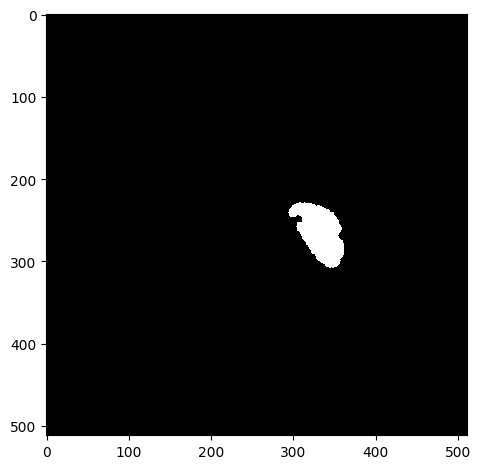

In [64]:
blood_label_colour = label2rgb(binary)

label_image = measure.label(binary)
region_props = measure.regionprops(label_image)

label_img_filter = label_image 
min_area = 2000 
max_area = 5000 

for region in region_props:
    if region.area>max_area or region.area<min_area:
        for cords in region.coords:
            label_img_filter[cords[0],cords[1]] = 0 
    
i_blood = label_img_filter > 0
io.imshow(i_blood)

In [65]:
blood_bin = bloodGT>0
print(1-distance.dice(i_blood.flatten(),blood_bin.flatten()))

0.9375729288214703


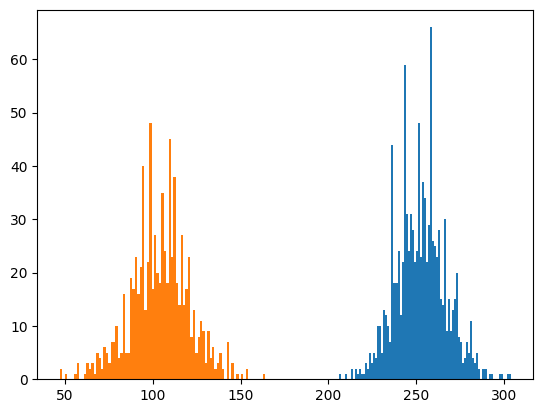

In [71]:
import matplotlib.pyplot as plt 

plt.hist(bloodroi_px,bins=85)
plt.hist(myc_px,bins=85)
plt.show()

In [76]:
myc_px.max() + std_m
#bloodroi_px.min()

180.8572947125076

In [51]:

def heart_pixel_analysis_e_2023():
    import matplotlib.pyplot as plt
    import numpy as np
    import pydicom as dicom
    from skimage.morphology import erosion, dilation, binary_closing, binary_opening
    from skimage.morphology import disk
    from skimage.morphology import square
    from skimage.filters import median
    from scipy.stats import norm
    from skimage import color, io, measure, img_as_ubyte, img_as_float
    from skimage.filters import threshold_otsu
    from scipy.spatial import distance
    from skimage.transform import rotate
    from skimage.transform import SimilarityTransform
    from skimage.transform import warp
    from skimage.transform import matrix_transform
    import glob
    from sklearn.decomposition import PCA
    import random
    from skimage.filters import prewitt_h
    from skimage.filters import prewitt_v
    import SimpleITK as sitk
    in_dir = "HeartCT/"
    im_name = "1-001.dcm"

    ct = dicom.read_file(in_dir + im_name)
    img = ct.pixel_array

    myo_roi = io.imread(in_dir + 'MyocardiumROI.png')
    myo_mask = myo_roi > 0
    myo_values = img[myo_mask]
    (mu_myo, std_myo) = norm.fit(myo_values)
    print(f"Myo: Average {mu_myo:.0f} standard deviation {std_myo:.0f}")

    blood_roi = io.imread(in_dir + 'bloodRoi.png')
    blood_mask = blood_roi > 0
    blood_values = img[blood_mask]
    (mu_blood, std_blood) = norm.fit(blood_values)
    print(f"Blood: Average {mu_blood:.0f} standard deviation {std_blood:.0f}")

    blood_gt = io.imread(in_dir + 'bloodGT.png')

    threshold = (mu_myo + mu_blood) / 2
    print(f"Answer: Threshold {threshold:.0f}")

    min_hu = mu_blood - 3 * std_blood
    max_hu = mu_blood + 3 * std_blood
    print(f"Answer: HU limits : {min_hu:0.2f} {max_hu:0.2f}")

    bin_img = (img > min_hu) & (img < max_hu)
    blood_label_colour = color.label2rgb(bin_img)
    io.imshow(blood_label_colour)
    plt.title("First blood estimate")
    io.show()

    footprint = disk(3)
    closing = binary_closing(bin_img, footprint)
    io.imshow(closing)
    plt.title("Second blood estimate")
    io.show()

    footprint = disk(5)
    opening = binary_opening(closing, footprint)
    io.imshow(opening)
    plt.title("Third blood estimate")
    io.show()

    label_img = measure.label(opening)
    n_labels = label_img.max()
    print(f"Answer: Number of labels: {n_labels}")

    region_props = measure.regionprops(label_img)

    min_area = 2000
    max_area = 5000

    # Create a copy of the label_img
    label_img_filter = label_img.copy()
    for region in region_props:
        a = region.area
        # p = region.perimeter
        print(a)
        if a < min_area or a > max_area:
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0

    # Create binary image from the filtered label image
    i_blood = label_img_filter > 0
    io.imshow(i_blood)
    io.show()
    
    gt_bin = blood_gt > 0
    dice_score = 1 - distance.dice(i_blood.ravel(), gt_bin.ravel())
    print(f"Answer: DICE score {dice_score:.3f}")

Myo: Average 104 standard deviation 17
Blood: Average 253 standard deviation 14
Answer: Threshold 178
Answer: HU limits : 209.99 295.59


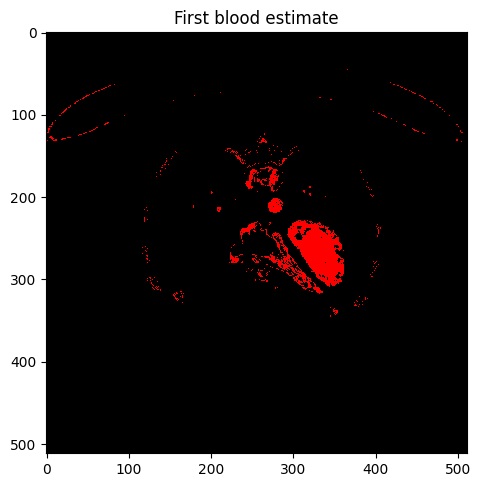

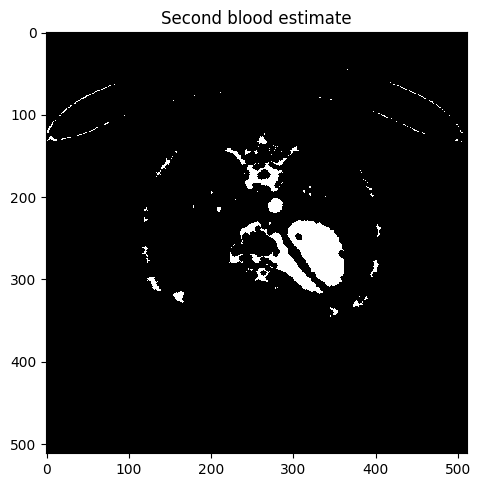

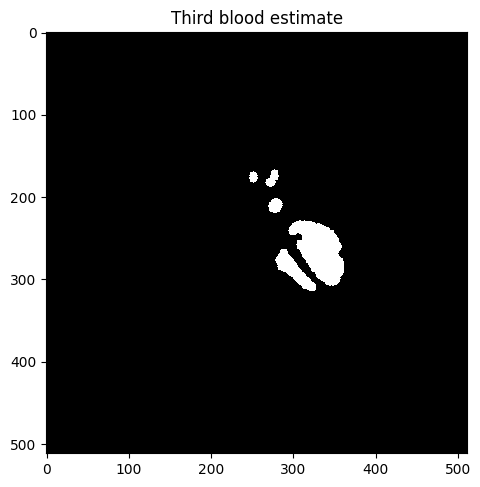

Answer: Number of labels: 5
209.0
112.0
240.0
3246.0
968.0


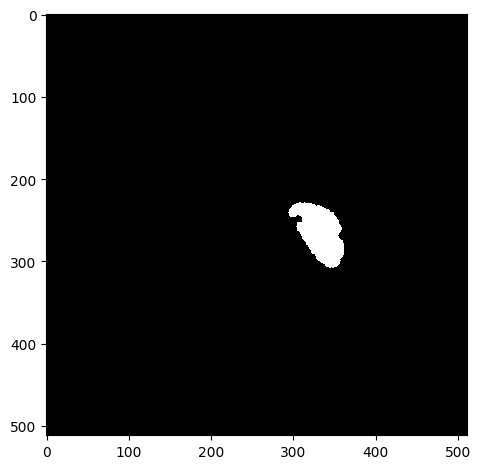

Answer: DICE score 0.938


In [52]:
heart_pixel_analysis_e_2023()